In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
import torch
import yaml


from plot_utils import load_model_and_data, sample_posteriors

TARGET_COLS = [
    'last T_coll', 'last V_coll', 'last MCrit500 coll',
    'last Subcluster mass', 'last Mass ratio', 'last d_peri'
]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                params_path: str = "params.yaml",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10,
                                max_ticks: int = 5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, X_full, Y_full, tar_sc = load_model_and_data(model_checkpoint, params_path, processed_dir, device)
    D_tar = Y_full.shape[1]

    _, idx_test = train_test_split(np.arange(len(X_full)), test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    Y_test_phys = tar_sc.inverse_transform(Y_test)

    all_data, results = [], []

    for d in range(D_tar):
        gt = Y_test_phys[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)
        bin_to_post = {b: [] for b in range(num_bins)}

        # Sample all posteriors
        samples_phys = sample_posteriors(model, X_test, tar_sc, n_samples_per_galaxy, device)

        for i, b in enumerate(bin_idx):
            bin_to_post[b].append(samples_phys[i, :, d])

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i = np.full(num_bins, np.nan)
        lo_i = np.full(num_bins, np.nan)
        hi_i = np.full(num_bins, np.nan)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if samples:
                arr = np.concatenate(samples)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_i[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo_i[b] = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi_i[b] = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # Plotting
    flat = np.concatenate([d.flatten() for d in all_data])
    pos = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    step = max(1, num_bins // max_ticks)
    tick_positions = np.arange(0, num_bins, step)
    if tick_positions[-1] != num_bins - 1:
        tick_positions = np.append(tick_positions, num_bins - 1)

    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)

    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]
        im = ax.imshow(data, origin='lower', norm=norm, aspect='equal',
                       interpolation='nearest', cmap='viridis')
        ax.plot([0, num_bins - 1], [0, num_bins - 1], color='white', linewidth=2)

        x_smooth = np.linspace(0, num_bins - 1, num_bins * 10)
        ax.plot(x_smooth, np.interp(x_smooth, np.arange(num_bins), med_i), '-', lw=3, color='black')
        ax.plot(x_smooth, np.interp(x_smooth, np.arange(num_bins), lo_i), '--', lw=3, color='black')
        ax.plot(x_smooth, np.interp(x_smooth, np.arange(num_bins), hi_i), '--', lw=3, color='black')

        ax.set_title(TARGET_COLS[d], fontsize=20)
        ax.set_xlabel('Prior bin end', fontsize=14)
        if d == 0:
            ax.set_ylabel('Posterior bin end', fontsize=14)

        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in tick_positions], rotation=90, fontsize=14)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in tick_positions], fontsize=14)

    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax).set_label('Number of samples (log scale)', fontsize=14)

    plt.tight_layout()
    #fig.savefig("prediction_performance1.pdf", bbox_inches='tight')
    fig.savefig("prediction_performance1.png", bbox_inches='tight')
    plt.show()

    return results


num samples out of bounds: 0
number of parameters: 727736


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CINN_spline/scalar/plot_utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allo

GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


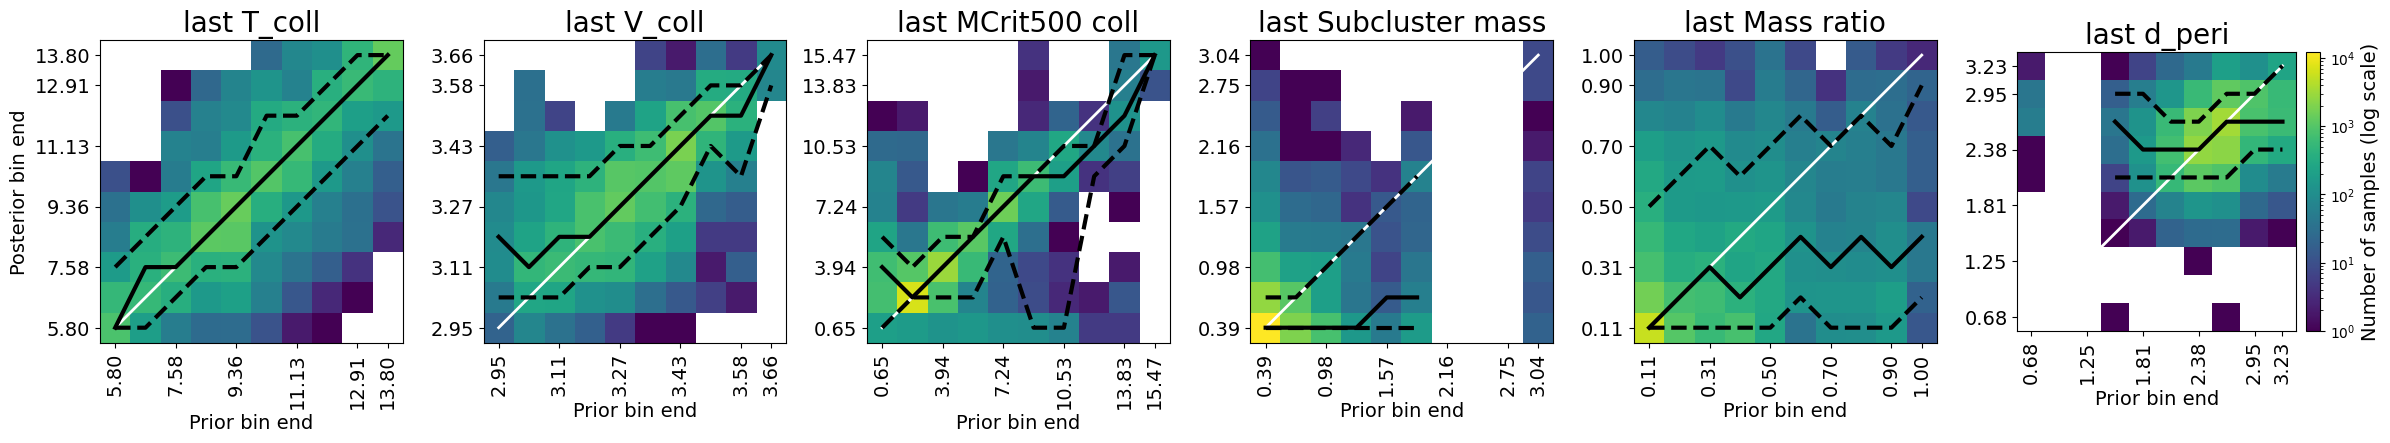

[(array([[ 858,  197,   55,   27,   28,   11,    2,    1,    0,    0],
         [ 531,  546,  363,  155,  208,   60,   13,    3,    1,    0],
         [ 175,  392,  632,  388,  417,   84,   38,   17,    4,    0],
         [  55,  351,  442, 1148, 1100,  127,   84,   50,   34,    3],
         [  34,  110,  180,  784, 1359,  368,  154,   61,   32,   11],
         [  10,    1,   52,  254,  566,  979,  552,  156,   61,   17],
         [   0,    0,   64,   56,  169,  402,  794,  325,  107,   38],
         [   0,    0,   10,   63,   84,  312,  419,  495,  202,  159],
         [   0,    0,    1,   24,   69,  129,   66,  382,  583,  446],
         [   0,    0,    0,    0,    0,   26,   78,  109,  471, 1323]]),
  array([0., 2., 2., 3., 4., 5., 6., 7., 8., 9.]),
  array([0., 0., 1., 2., 2., 3., 4., 5., 6., 7.]),
  array([2., 3., 4., 5., 5., 7., 7., 8., 9., 9.]),
  array([ 4.91636777,  5.80449258,  6.69261739,  7.58074221,  8.46886702,
          9.35699183, 10.24511665, 11.13324146, 12.02136627, 

In [5]:
plot_posteriors_all_targets(
    model_checkpoint="runs/20250530_211943_no_scaling/model_last.pt",
    processed_dir="processed_data",
    params_path="params.yaml",
    n_samples_per_galaxy=100,
    num_bins=10,
    random_state=42
)

In [6]:
# Updated version using plot_utils functions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from sklearn.neighbors import KernelDensity

from plot_utils import load_model_and_data, sample_posteriors, compute_map_estimates

TARGET_COLS = [
    'last T coll',
    'last V coll',
    'last MCrit500 coll',
    'last Subcluster mass',
    'last Mass ratio',
    'last d_peri'
]

def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    params_path: str = "params.yaml",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh: float = 0.1,
    random_state: int = 42,
    label_fontsize: int = 14,
    title_fontsize: int = 22
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model, X_full, Y_full, tar_sc = load_model_and_data(model_checkpoint, params_path, processed_dir, device)

    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # Split data to get test set
    _, idx_test = train_test_split(np.arange(N), test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)

    # Sample posteriors and compute MAPs
    samples_phys = sample_posteriors(model, X_test, tar_sc, n_samples=n_posterior_samples, device=device)
    maps_phys = compute_map_estimates(samples_phys, bandwidth=0.5)

    # Set up figure: 2 rows x D_tar columns
    fig, axes = plt.subplots(2, D_tar, figsize=(4 * D_tar, 10), squeeze=False)

    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        error = mapv - truth
        tmin, tmax = truth.min(), truth.max()

        # Top row: MAP vs Truth
        ax = axes[0, d]
        ax.scatter(truth, mapv, s=50, alpha=1.0, color='lightblue')
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', linewidth=2)

        # Bin statistics
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1

        med_map = np.full(num_bins, np.nan)
        lo_map  = np.full(num_bins, np.nan)
        hi_map  = np.full(num_bins, np.nan)

        for i_bin in range(num_bins):
            sel = mapv[inds == i_bin]
            if sel.size > 0:
                med_map[i_bin] = np.median(sel)
                lo_map[i_bin], hi_map[i_bin] = np.percentile(sel, [10, 90])

        ax.plot(centers, med_map, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo_map,  '--', linewidth=1.2, color='black')
        ax.plot(centers, hi_map,  '--', linewidth=1.2, color='black')

        ax.set_xlim(tmin, tmax)
        ax.set_ylim(tmin, tmax)
        ax.set_title(TARGET_COLS[d], fontsize=title_fontsize)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP estimate", fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=label_fontsize)

        # Bottom row: Error vs Truth
        ax = axes[1, d]
        ax.scatter(truth, error, s=50, alpha=1.0, color='lightblue')
        ax.axhline(0, color='peachpuff', linewidth=2)

        med_err = np.full(num_bins, np.nan)
        lo_err  = np.full(num_bins, np.nan)
        hi_err  = np.full(num_bins, np.nan)

        for i_bin in range(num_bins):
            sel = error[inds == i_bin]
            if sel.size > 0:
                med_err[i_bin] = np.median(sel)
                lo_err[i_bin], hi_err[i_bin] = np.percentile(sel, [16, 84])

        ax.plot(centers, med_err, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo_err,  '--', linewidth=1.2, color='gray')
        ax.plot(centers, hi_err,  '--', linewidth=1.2, color='gray')

        ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0)
        ax.set_xlim(tmin, tmax)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP − Ground Truth", fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=label_fontsize)

    plt.tight_layout()
    #fig.savefig("prediction_performance2.pdf", bbox_inches='tight')
    fig.savefig("prediction_performance2.png", bbox_inches='tight')
    plt.show()


num samples out of bounds: 0
number of parameters: 727736


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/vera/u/jshera/CINN_spline/scalar/plot_utils.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allo

GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


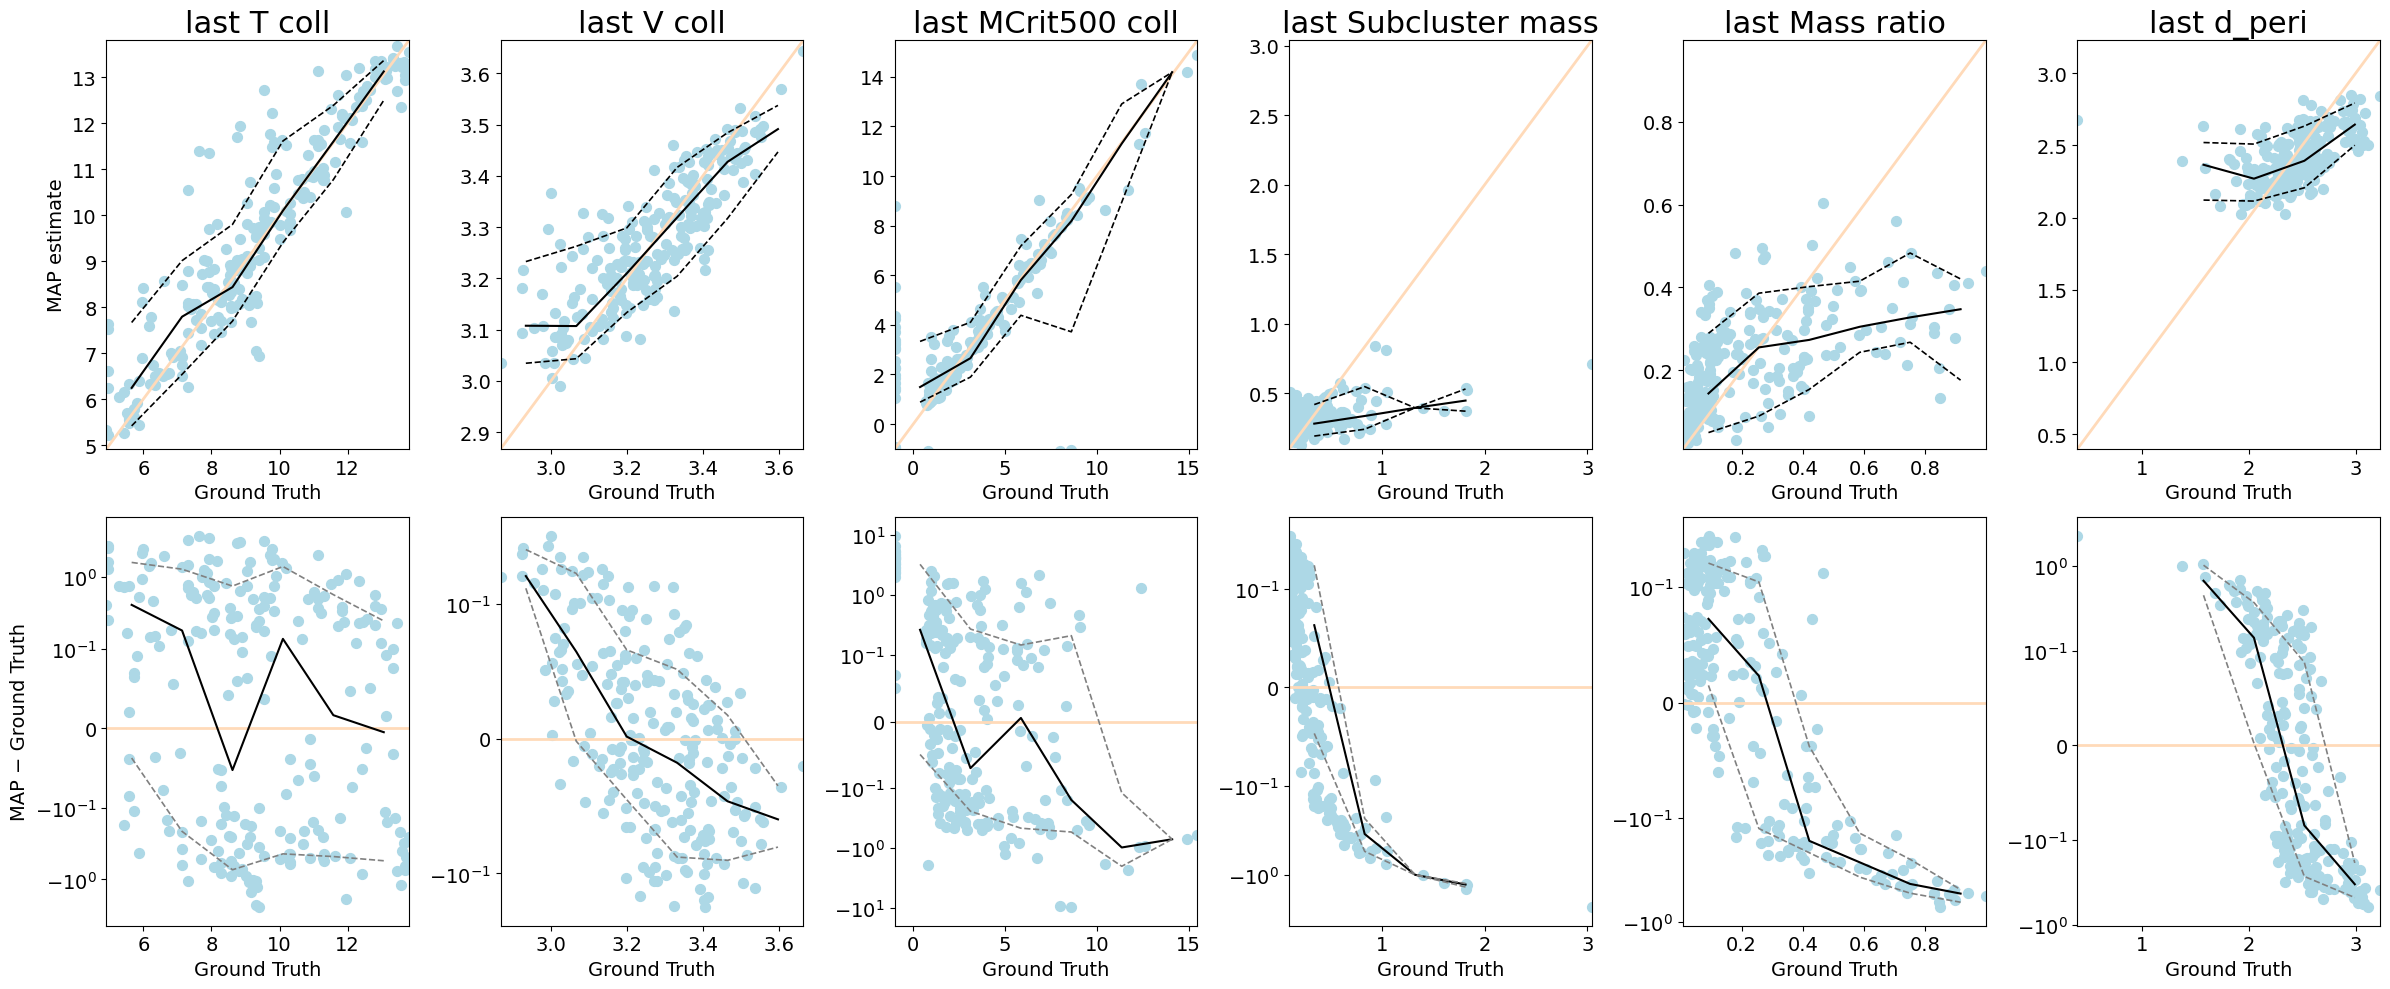

In [7]:
plot_map_and_error_vs_truth(
    model_checkpoint="runs/20250530_211943_no_scaling/model_last.pt",
    processed_dir="processed_data",
    params_path="params.yaml",
    n_posterior_samples=100,
    num_bins=6,
    linthresh=0.1,
    random_state=42
)